In [2]:
# ============================
# CELDA 1: IMPORTS Y CONFIGURACIÓN
# ============================

import os
import random
import pickle

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

import mlflow
import mlflow.pytorch

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch. cuda.is_available() else "cpu")
print("Dispositivo:", DEVICE)

# Rutas
DATA_DIR = "../data/processed"
MODELS_DIR = "../models"
MLRUNS_DIR = "../mlruns"

# MLflow
mlruns_absolute = os.path.abspath(MLRUNS_DIR)
mlflow.set_tracking_uri(f"file:///{mlruns_absolute}")

print(f"DATA_DIR: {os.path.abspath(DATA_DIR)}")
print(f"MODELS_DIR: {os. path.abspath(MODELS_DIR)}")
print(f"MLRUNS_DIR: {mlruns_absolute}")

Dispositivo: cpu
DATA_DIR: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\data\processed
MODELS_DIR: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\models
MLRUNS_DIR: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\mlruns


In [3]:
# ==========================================
# CELDA 2: CARGA DE DATOS
# ==========================================

pkl_path = "../data/processed/youtube_all_versions.pkl"

with open(pkl_path, "rb") as f:
    data = pickle.load(f)

if isinstance(data, pd.DataFrame):
    df = data. copy()
else:
    print("Claves disponibles:", list(data.keys()))
    df = data["text_clean"]. copy()

print(f"Total muestras: {len(df)}")
print(f"\nDistribución:")
print(df["IsHate"].value_counts())
print(df["IsHate"]. value_counts(normalize=True))

Total muestras: 997

Distribución:
IsHate
False    538
True     459
Name: count, dtype: int64
IsHate
False    0.539619
True     0.460381
Name: proportion, dtype: float64


In [4]:
# ==========================================
# CELDA 3: CONFIGURACIÓN
# ==========================================

MODEL_NAME = "bert-base-multilingual-cased"

MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 8
LR = 2e-5
WARMUP_RATIO = 0.1

print(f"Modelo: {MODEL_NAME}")

Modelo: bert-base-multilingual-cased


In [5]:
# ==========================================
# CELDA 4: PREPARACIÓN DE DATOS
# ==========================================

TEXT_COL = "Text"
TARGET_COL = "IsHate"

df_model = df[[TEXT_COL, TARGET_COL]].dropna(). copy()
df_model = df_model[df_model[TEXT_COL].str.strip().str.len() > 3]

X = df_model[TEXT_COL]. values
y = df_model[TARGET_COL].values. astype(int)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.18, stratify=y_temp, random_state=SEED
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 693 | Val: 153 | Test: 150


In [6]:
# ==========================================
# CELDA 5: AUGMENTATION (CONFIGURACIÓN GANADORA)
# ==========================================

def simple_augment(text):
    words = text.split()
    if len(words) < 4:
        return text
    
    choice = random.random()
    if choice < 0.33:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
    elif choice < 0.66:
        del_idx = random.randint(0, len(words) - 1)
        words. pop(del_idx)
    
    return " ".join(words)

def balance_dataset_moderate(X, y, augment_ratio=0.5):
    X_list, y_list = list(X), list(y)
    
    counts = np.bincount(y)
    print(f"Original - Clase 0: {counts[0]}, Clase 1: {counts[1]}")
    
    minority = 1 if counts[1] < counts[0] else 0
    majority = 1 - minority
    
    minority_texts = [X_list[i] for i in range(len(y_list)) if y_list[i] == minority]
    majority_texts = [X_list[i] for i in range(len(y_list)) if y_list[i] == majority]
    
    n_to_add_min = int(len(minority_texts) * augment_ratio)
    for _ in range(n_to_add_min):
        text = random.choice(minority_texts)
        X_list.append(simple_augment(text))
        y_list.append(minority)
    
    n_to_add_maj = int(len(majority_texts) * 0.2)
    for _ in range(n_to_add_maj):
        text = random.choice(majority_texts)
        X_list.append(simple_augment(text))
        y_list.append(majority)
    
    combined = list(zip(X_list, y_list))
    random.shuffle(combined)
    X_aug, y_aug = zip(*combined)
    
    new_counts = np.bincount(y_aug)
    print(f"Augmentado - Clase 0: {new_counts[0]}, Clase 1: {new_counts[1]}")
    
    return np.array(X_aug), np.array(y_aug)

X_train_aug, y_train_aug = balance_dataset_moderate(X_train, y_train, augment_ratio=0.5)

Original - Clase 0: 374, Clase 1: 319
Augmentado - Clase 0: 448, Clase 1: 478


In [7]:
# ==========================================
# CELDA 6: DATASET Y DATALOADERS
# ==========================================

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class HateDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self. max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch. long)
        }

train_dataset = HateDataset(X_train_aug, y_train_aug, tokenizer, MAX_LENGTH)
val_dataset = HateDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = HateDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Weighted sampler
class_counts = np.bincount(y_train_aug)
sample_weights = [1.0 / class_counts[label] for label in y_train_aug]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches - Train: {len(train_loader)} | Val: {len(val_loader)}")

Batches - Train: 29 | Val: 5


In [8]:
# ==========================================
# CELDA 7: MODELO
# ==========================================

from transformers import AutoConfig

config = AutoConfig. from_pretrained(MODEL_NAME)
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2
config.num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)
model.to(DEVICE)

# Congelar 6 capas
for param in model.bert. embeddings.parameters():
    param.requires_grad = False

for i in range(6):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p. numel() for p in model.parameters())
print(f"Parámetros entrenables: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parámetros entrenables: 43,119,362 / 177,854,978 (24.2%)


In [9]:
# ==========================================
# CELDA 8: LOSS Y OPTIMIZER
# ==========================================

class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train_aug)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float). to(DEVICE)

criterion = nn. CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
print(f"Class weights: {class_weights}")

optimizer = torch.optim.AdamW(
    filter(lambda p: p. requires_grad, model.parameters()),
    lr=LR,
    weight_decay=0.05
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

Class weights: [1.03348214 0.96861925]


In [10]:
# ==========================================
# CELDA 8: LOSS Y OPTIMIZER (CORREGIDO)
# ==========================================

class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train_aug)
# NO reducir el peso - dejarlo balanceado
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float). to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
print(f"Class weights: {class_weights}")

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=0.05
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

Class weights: [1.03348214 0.96861925]


In [11]:
# ==========================================
# CELDA 9: OPTIMIZER Y SCHEDULER
# ==========================================

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=0.05
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Total steps: {total_steps} | Warmup: {warmup_steps}")

Total steps: 232 | Warmup: 23


In [12]:
# ==========================================
# CELDA 10: FUNCIONES DE ENTRENAMIENTO
# ==========================================

def train_epoch(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"]. to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs. logits, labels)
        
        loss.backward()
        torch.nn.utils. clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item() * len(labels)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu(). numpy())
    
    return {
        "loss": total_loss / len(loader. dataset),
        "f1": f1_score(all_labels, all_preds, average="binary"),
        "precision": precision_score(all_labels, all_preds, average="binary", zero_division=0),
        "recall": recall_score(all_labels, all_preds, average="binary", zero_division=0)
    }

def eval_epoch(model, loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"]. to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return {
        "f1": f1_score(all_labels, all_preds, average="binary"),
        "precision": precision_score(all_labels, all_preds, average="binary", zero_division=0),
        "recall": recall_score(all_labels, all_preds, average="binary", zero_division=0)
    }, all_labels, all_preds, all_probs

In [13]:
# ==========================================
# CELDA 11: ENTRENAMIENTO CON CONTROL DE OVERFITTING
# ==========================================

mlflow.set_experiment("bert_multilingual_final")

PATIENCE = 3
MAX_GAP = 0.06  # Máximo gap permitido
best_val_f1 = 0
best_gap = 1.0
patience_counter = 0
best_model_state = None
best_epoch = 0

history = {"train_f1": [], "val_f1": [], "gap": []}

with mlflow.start_run(run_name="bert_controlled_gap"):
    for epoch in range(1, EPOCHS + 1):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch}/{EPOCHS}")
        print('='*50)
        
        train_metrics = train_epoch(model, train_loader, optimizer, scheduler, criterion, DEVICE)
        val_metrics, _, _, _ = eval_epoch(model, val_loader, DEVICE)
        
        gap = train_metrics["f1"] - val_metrics["f1"]
        
        history["train_f1"].append(train_metrics["f1"])
        history["val_f1"].append(val_metrics["f1"])
        history["gap"].append(gap)
        
        print(f"Train - Loss: {train_metrics['loss']:.4f} | F1: {train_metrics['f1']:.4f}")
        print(f"Val   - F1: {val_metrics['f1']:.4f} | P: {val_metrics['precision']:.4f} | R: {val_metrics['recall']:.4f}")
        print(f"Gap: {gap:.4f} (máx: {MAX_GAP})")
        
        # CRITERIO: mejor F1 CON gap aceptable
        is_better = False
        
        if gap <= MAX_GAP:
            # Si gap es aceptable, guardar si mejora F1
            if val_metrics["f1"] > best_val_f1:
                is_better = True
                print(f"✓ Mejor modelo!  (gap OK: {gap:.4f} <= {MAX_GAP})")
        else:
            # Si gap es alto, solo guardar si es mucho mejor Y es el primer modelo
            if best_model_state is None:
                is_better = True
                print(f"⚠️ Guardando con gap alto (no hay modelo previo)")
            else:
                print(f"✗ Gap muy alto ({gap:.4f} > {MAX_GAP}), no guardado")
        
        if is_better:
            best_val_f1 = val_metrics["f1"]
            best_gap = gap
            best_epoch = epoch
            patience_counter = 0
            best_model_state = {k: v. cpu(). clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{PATIENCE}")
        
        # Early stopping
        if patience_counter >= PATIENCE:
            print("\n>>> Early stopping!")
            break
        
        # Parar si gap crece mucho
        if gap > 0.12:
            print("\n>>> Stopping: overfitting severo")
            break

    # Restaurar mejor modelo
    if best_model_state:
        model.load_state_dict(best_model_state)
        model.to(DEVICE)

    print(f"\n{'='*50}")
    print(f"MEJOR MODELO: Época {best_epoch}")
    print(f"Val F1: {best_val_f1:.4f} | Gap: {best_gap:.4f}")
    print('='*50)

c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)



Epoch 1/8
Train - Loss: 0.6906 | F1: 0.4527
Val   - F1: 0.6624 | P: 0.6047 | R: 0.7324
Gap: -0.2097 (máx: 0.06)
✓ Mejor modelo!  (gap OK: -0.2097 <= 0.06)

Epoch 2/8
Train - Loss: 0.6470 | F1: 0.6552
Val   - F1: 0.6531 | P: 0.6316 | R: 0.6761
Gap: 0.0022 (máx: 0.06)
Patience: 1/3

Epoch 3/8
Train - Loss: 0.5753 | F1: 0.7032
Val   - F1: 0.6718 | P: 0.7333 | R: 0.6197
Gap: 0.0315 (máx: 0.06)
✓ Mejor modelo!  (gap OK: 0.0315 <= 0.06)

Epoch 4/8
Train - Loss: 0.5139 | F1: 0.7867
Val   - F1: 0.6968 | P: 0.6429 | R: 0.7606
Gap: 0.0899 (máx: 0.06)
✗ Gap muy alto (0.0899 > 0.06), no guardado
Patience: 1/3

Epoch 5/8
Train - Loss: 0.5370 | F1: 0.7534
Val   - F1: 0.7050 | P: 0.7206 | R: 0.6901
Gap: 0.0484 (máx: 0.06)
✓ Mejor modelo!  (gap OK: 0.0484 <= 0.06)

Epoch 6/8
Train - Loss: 0.4662 | F1: 0.8273
Val   - F1: 0.7273 | P: 0.6747 | R: 0.7887
Gap: 0.1000 (máx: 0.06)
✗ Gap muy alto (0.1000 > 0.06), no guardado
Patience: 1/3

Epoch 7/8
Train - Loss: 0.4388 | F1: 0.8565
Val   - F1: 0.7006 | P: 0

In [14]:
# ==========================================
# CELDA 12: EVALUACIÓN COMPLETA
# ==========================================

def find_best_threshold_balanced(y_true, y_probs):
    """Encuentra umbral óptimo priorizando F1 y balance P/R."""
    thresholds = np. arange(0.30, 0.65, 0.02)
    results = []
    
    for thresh in thresholds:
        y_pred_thresh = (np.array(y_probs) >= thresh).astype(int)
        
        p = precision_score(y_true, y_pred_thresh, zero_division=0)
        r = recall_score(y_true, y_pred_thresh, zero_division=0)
        f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
        
        balance_penalty = abs(p - r) * 0.05
        adjusted_f1 = f1 - balance_penalty
        
        results.append({
            "threshold": thresh,
            "precision": p,
            "recall": r,
            "f1": f1,
            "adjusted_f1": adjusted_f1,
            "p_r_diff": abs(p - r)
        })
    
    results_df = pd.DataFrame(results)
    best_idx = results_df["adjusted_f1"]. idxmax()
    
    return results_df.loc[best_idx], results_df

# Evaluación
test_metrics, y_true, y_pred, y_probs = eval_epoch(model, test_loader, DEVICE)

print("="*50)
print("RESULTADOS CON UMBRAL 0.5")
print("="*50)
print(f"F1:        {test_metrics['f1']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")

# Umbral óptimo
best_thresh, all_results = find_best_threshold_balanced(y_true, y_probs)

print("\n" + "="*50)
print(f"RESULTADOS CON UMBRAL ÓPTIMO ({best_thresh['threshold']:.2f})")
print("="*50)

optimal_threshold = best_thresh['threshold']
y_pred_optimal = (np.array(y_probs) >= optimal_threshold).astype(int)

print(f"F1:        {best_thresh['f1']:.4f}")
print(f"Precision: {best_thresh['precision']:.4f}")
print(f"Recall:    {best_thresh['recall']:.4f}")
print(f"Balance:   {best_thresh['p_r_diff']:.4f}")

print("\n" + classification_report(y_true, y_pred_optimal, digits=4, target_names=['No Hate', 'Hate']))

# Comparación
print("="*50)
print("COMPARACIÓN CON RESULTADOS ANTERIORES")
print("="*50)
print(f"{'Versión':<25} {'F1':>8} {'P':>8} {'R':>8}")
print("-"*50)
print(f"{'TinyBERT original':<25} {'0.64':>8} {'-':>8} {'-':>8}")
print(f"{'Multilingual v1':<25} {'0.71':>8} {'0.75':>8} {'0.67':>8}")
print(f"{'Anterior (umbral 0.40)':<25} {'0.755':>8} {'0.73':>8} {'0.78':>8}")
print(f"{'Este modelo':<25} {best_thresh['f1']:>8.3f} {best_thresh['precision']:>8.2f} {best_thresh['recall']:>8.2f}")

RESULTADOS CON UMBRAL 0.5
F1:        0.7206
Precision: 0.7313
Recall:    0.7101

RESULTADOS CON UMBRAL ÓPTIMO (0.44)
F1:        0.7413
Precision: 0.7162
Recall:    0.7681
Balance:   0.0519

              precision    recall  f1-score   support

     No Hate     0.7895    0.7407    0.7643        81
        Hate     0.7162    0.7681    0.7413        69

    accuracy                         0.7533       150
   macro avg     0.7528    0.7544    0.7528       150
weighted avg     0.7558    0.7533    0.7537       150

COMPARACIÓN CON RESULTADOS ANTERIORES
Versión                         F1        P        R
--------------------------------------------------
TinyBERT original             0.64        -        -
Multilingual v1               0.71     0.75     0.67
Anterior (umbral 0.40)       0.755     0.73     0.78
Este modelo                  0.741     0.72     0.77


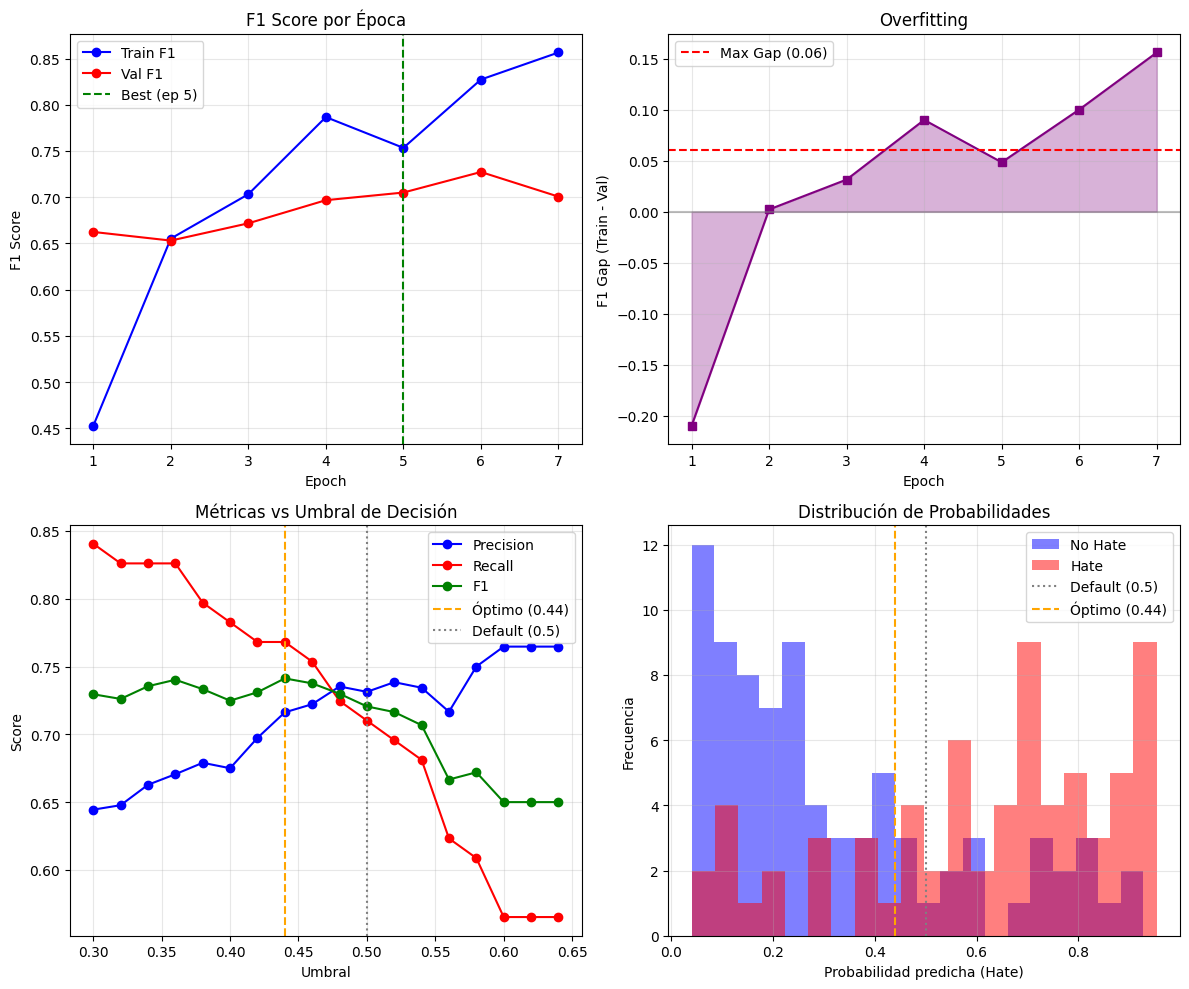

In [ ]:
# ==========================================
# CELDA 13: VISUALIZACIÓN MEJORADA
# ==========================================

import matplotlib.pyplot as plt

fig, axes = plt. subplots(2, 2, figsize=(12, 10))

epochs_range = range(1, len(history["train_f1"]) + 1)

# 1. F1 scores
ax1 = axes[0, 0]
ax1.plot(epochs_range, history["train_f1"], 'b-o', label='Train F1')
ax1.plot(epochs_range, history["val_f1"], 'r-o', label='Val F1')
if best_epoch <= len(history["train_f1"]):
    ax1.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best (ep {best_epoch})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score por Época')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Gap (Overfitting)
ax2 = axes[0, 1]
ax2.plot(epochs_range, history["gap"], 'purple', marker='s')
ax2.axhline(y=MAX_GAP, color='r', linestyle='--', label=f'Max Gap ({MAX_GAP})')
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax2.fill_between(epochs_range, 0, history["gap"], alpha=0.3, color='purple')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Gap (Train - Val)')
ax2.set_title('Overfitting')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3.  Precision vs Recall por umbral
ax3 = axes[1, 0]
ax3.plot(all_results["threshold"], all_results["precision"], 'b-o', label='Precision')
ax3.plot(all_results["threshold"], all_results["recall"], 'r-o', label='Recall')
ax3.plot(all_results["threshold"], all_results["f1"], 'g-o', label='F1')
ax3.axvline(x=optimal_threshold, color='orange', linestyle='--', label=f'Óptimo ({optimal_threshold:.2f})')
ax3.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax3.set_xlabel('Umbral')
ax3.set_ylabel('Score')
ax3.set_title('Métricas vs Umbral de Decisión')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Distribución de probabilidades
ax4 = axes[1, 1]
y_probs_arr = np.array(y_probs)
y_true_arr = np. array(y_true)

ax4.hist(y_probs_arr[y_true_arr == 0], bins=20, alpha=0.5, label='No Hate', color='blue')
ax4.hist(y_probs_arr[y_true_arr == 1], bins=20, alpha=0.5, label='Hate', color='red')
ax4.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax4.axvline(x=optimal_threshold, color='orange', linestyle='--', label=f'Óptimo ({optimal_threshold:.2f})')
ax4.set_xlabel('Probabilidad predicha (Hate)')
ax4.set_ylabel('Frecuencia')
ax4. set_title('Distribución de Probabilidades')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt. tight_layout()
plt.show()

In [18]:
# ==========================================
# CELDA 15: GUARDAR MODELO COMPLETO EN UN PKL
# ==========================================

import pickle

# Crear diccionario con todo lo necesario
model_package = {
    # Modelo y tokenizer
    "model_state_dict": model. state_dict(),
    "model_name": MODEL_NAME,
    "num_labels": 2,
    "max_length": MAX_LENGTH,
    
    # Configuración del modelo
    "config": {
        "hidden_dropout_prob": 0.2,
        "attention_probs_dropout_prob": 0.2
    },
    
    # Umbral óptimo
    "optimal_threshold": float(optimal_threshold),
    
    # Métricas
    "metrics": {
        "test_f1_default": float(test_metrics["f1"]),
        "test_f1_optimal": float(best_thresh["f1"]),
        "test_precision": float(best_thresh["precision"]),
        "test_recall": float(best_thresh["recall"]),
        "best_epoch": best_epoch
    }
}

# Guardar en un solo archivo
save_path = "../models/hate_speech_model.pkl"

with open(save_path, "wb") as f:
    pickle.dump(model_package, f)

print(f"✓ Modelo guardado en: {save_path}")
print(f"✓ Umbral óptimo: {optimal_threshold:.2f}")
print(f"✓ F1 con umbral óptimo: {best_thresh['f1']:.4f}")

✓ Modelo guardado en: ../models/hate_speech_model.pkl
✓ Umbral óptimo: 0.44
✓ F1 con umbral óptimo: 0.7413


In [19]:
# ==========================================
# CELDA 16: CLASE PARA PREDICCIONES (PARA STREAMLIT)
# ==========================================

class HateSpeechDetector:
    """
    Detector de discurso de odio para usar en Streamlit. 
    """
    
    def __init__(self, model_path="../models/hate_speech_model.pkl"):
        """Carga el modelo desde el archivo pkl."""
        import pickle
        import torch
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
        
        # Cargar el paquete
        with open(model_path, "rb") as f:
            self.package = pickle. load(f)
        
        self.device = torch.device("cuda" if torch. cuda.is_available() else "cpu")
        self.max_length = self. package["max_length"]
        self.threshold = self.package["optimal_threshold"]
        
        # Cargar tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.package["model_name"])
        
        # Cargar modelo
        config = AutoConfig.from_pretrained(self.package["model_name"])
        config.num_labels = self.package["num_labels"]
        config.hidden_dropout_prob = self.package["config"]["hidden_dropout_prob"]
        config.attention_probs_dropout_prob = self.package["config"]["attention_probs_dropout_prob"]
        
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.package["model_name"],
            config=config,
            ignore_mismatched_sizes=True
        )
        self.model.load_state_dict(self.package["model_state_dict"])
        self.model.to(self. device)
        self.model.eval()
    
    def predict(self, text):
        """
        Predice si un texto es discurso de odio.
        
        Args:
            text: str o lista de str
            
        Returns:
            dict con predicción, probabilidad y etiqueta
        """
        import torch
        
        # Si es un solo texto, convertir a lista
        single_input = isinstance(text, str)
        if single_input:
            texts = [text]
        else:
            texts = text
        
        results = []
        
        with torch.no_grad():
            for t in texts:
                # Tokenizar
                encoding = self.tokenizer(
                    t,
                    max_length=self. max_length,
                    truncation=True,
                    padding="max_length",
                    return_tensors="pt"
                )
                
                input_ids = encoding["input_ids"].to(self.device)
                attention_mask = encoding["attention_mask"].to(self.device)
                
                # Predecir
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.softmax(outputs.logits, dim=1)
                prob_hate = probs[0, 1].item()
                
                # Aplicar umbral óptimo
                is_hate = prob_hate >= self.threshold
                
                results.append({
                    "text": t,
                    "is_hate": is_hate,
                    "probability": prob_hate,
                    "label": "Hate" if is_hate else "No Hate",
                    "confidence": prob_hate if is_hate else 1 - prob_hate
                })
        
        return results[0] if single_input else results
    
    def get_metrics(self):
        """Retorna las métricas del modelo."""
        return self.package["metrics"]
    
    def get_threshold(self):
        """Retorna el umbral óptimo."""
        return self.threshold


# Probar que funciona
print("Probando el detector...")
detector = HateSpeechDetector("../models/hate_speech_model.pkl")

# Ejemplos de prueba
test_texts = [
    "I love this video, great content!",
    "You are stupid and I hate you",
    "Thanks for sharing this information"
]

print("\nPredicciones de prueba:")
print("-" * 60)
for text in test_texts:
    result = detector.predict(text)
    print(f"Texto: {text[:50]}...")
    print(f"  → {result['label']} (prob: {result['probability']:.3f}, conf: {result['confidence']:.3f})")
    print()

print("Métricas del modelo:")
print(detector.get_metrics())

Probando el detector...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Predicciones de prueba:
------------------------------------------------------------
Texto: I love this video, great content!...
  → No Hate (prob: 0.034, conf: 0.966)

Texto: You are stupid and I hate you...
  → No Hate (prob: 0.184, conf: 0.816)

Texto: Thanks for sharing this information...
  → No Hate (prob: 0.039, conf: 0.961)

Métricas del modelo:
{'test_f1_default': 0.7205882352941176, 'test_f1_optimal': 0.7412587412587412, 'test_precision': 0.7162162162162162, 'test_recall': 0.7681159420289855, 'best_epoch': 5}
